In [65]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [66]:
#Importing needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [67]:
#reading the dataset
countries = pd.read_csv("./Country-data.csv")

In [68]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [69]:
countries.isnull().sum()
#No Null values

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [70]:
countries.info()
#All are numerical features expect country

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [71]:
#Checking for outliers
countries.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,70.800000,10.940000,75.420000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,80.570000,11.570000,81.140000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,160.480000,13.474000,146.080000,84374.000000,41.478000,82.370000,6.563600,79088.000000


In [72]:
#Deleting countries having very high income, gdpp and exports - these outliers will impact clustering

countries.loc[(countries.income > countries.income.quantile(0.95)) & (countries.gdpp > countries.gdpp.quantile(0.95)) ]

countries = countries.loc[~((countries.income > countries.income.quantile(0.95)) & (countries.gdpp > countries.gdpp.quantile(0.95)) )]

countries  = countries.loc[countries.exports < countries.exports.quantile(0.99)]

#Not doing anything for lower values as our target is to find out poorest countries and it might lead to loss of data

In [73]:
countries.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,39.515528,38.330429,6.801553,45.062521,15082.378882,7.943571,70.160248,2.997702,10929.279503
std,40.543399,20.436587,2.722509,19.230146,15240.204221,10.721082,8.810848,1.518084,14305.742085
min,2.600000,0.109000,1.970000,0.065900,609.000000,-4.210000,32.100000,1.230000,231.000000
25%,10.000000,23.500000,4.930000,30.400000,3320.000000,1.850000,64.600000,1.860000,1310.000000
50%,20.300000,34.800000,6.220000,43.200000,9920.000000,5.440000,72.500000,2.480000,4540.000000
75%,62.200000,50.600000,8.500000,58.100000,21100.000000,11.100000,76.500000,4.080000,12600.000000
90%,101.000000,67.400000,10.900000,70.700000,39800.000000,16.700000,80.100000,5.340000,35800.000000
95%,116.000000,76.400000,11.600000,79.900000,44000.000000,20.900000,81.300000,5.870000,46200.000000
99%,154.000000,89.660000,13.540000,95.960000,64640.000000,41.880000,82.000000,6.566000,51980.000000


In [74]:
countries.shape
#Deleted 6 entries 

(161, 10)

In [75]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 166
Data columns (total 10 columns):
country       161 non-null object
child_mort    161 non-null float64
exports       161 non-null float64
health        161 non-null float64
imports       161 non-null float64
income        161 non-null int64
inflation     161 non-null float64
life_expec    161 non-null float64
total_fer     161 non-null float64
gdpp          161 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.8+ KB


In [76]:
#Consideration points - 
#Socio-Economic and Health factors - high child_mort, poor health spending, poor life_expec

<Figure size 1440x1440 with 0 Axes>

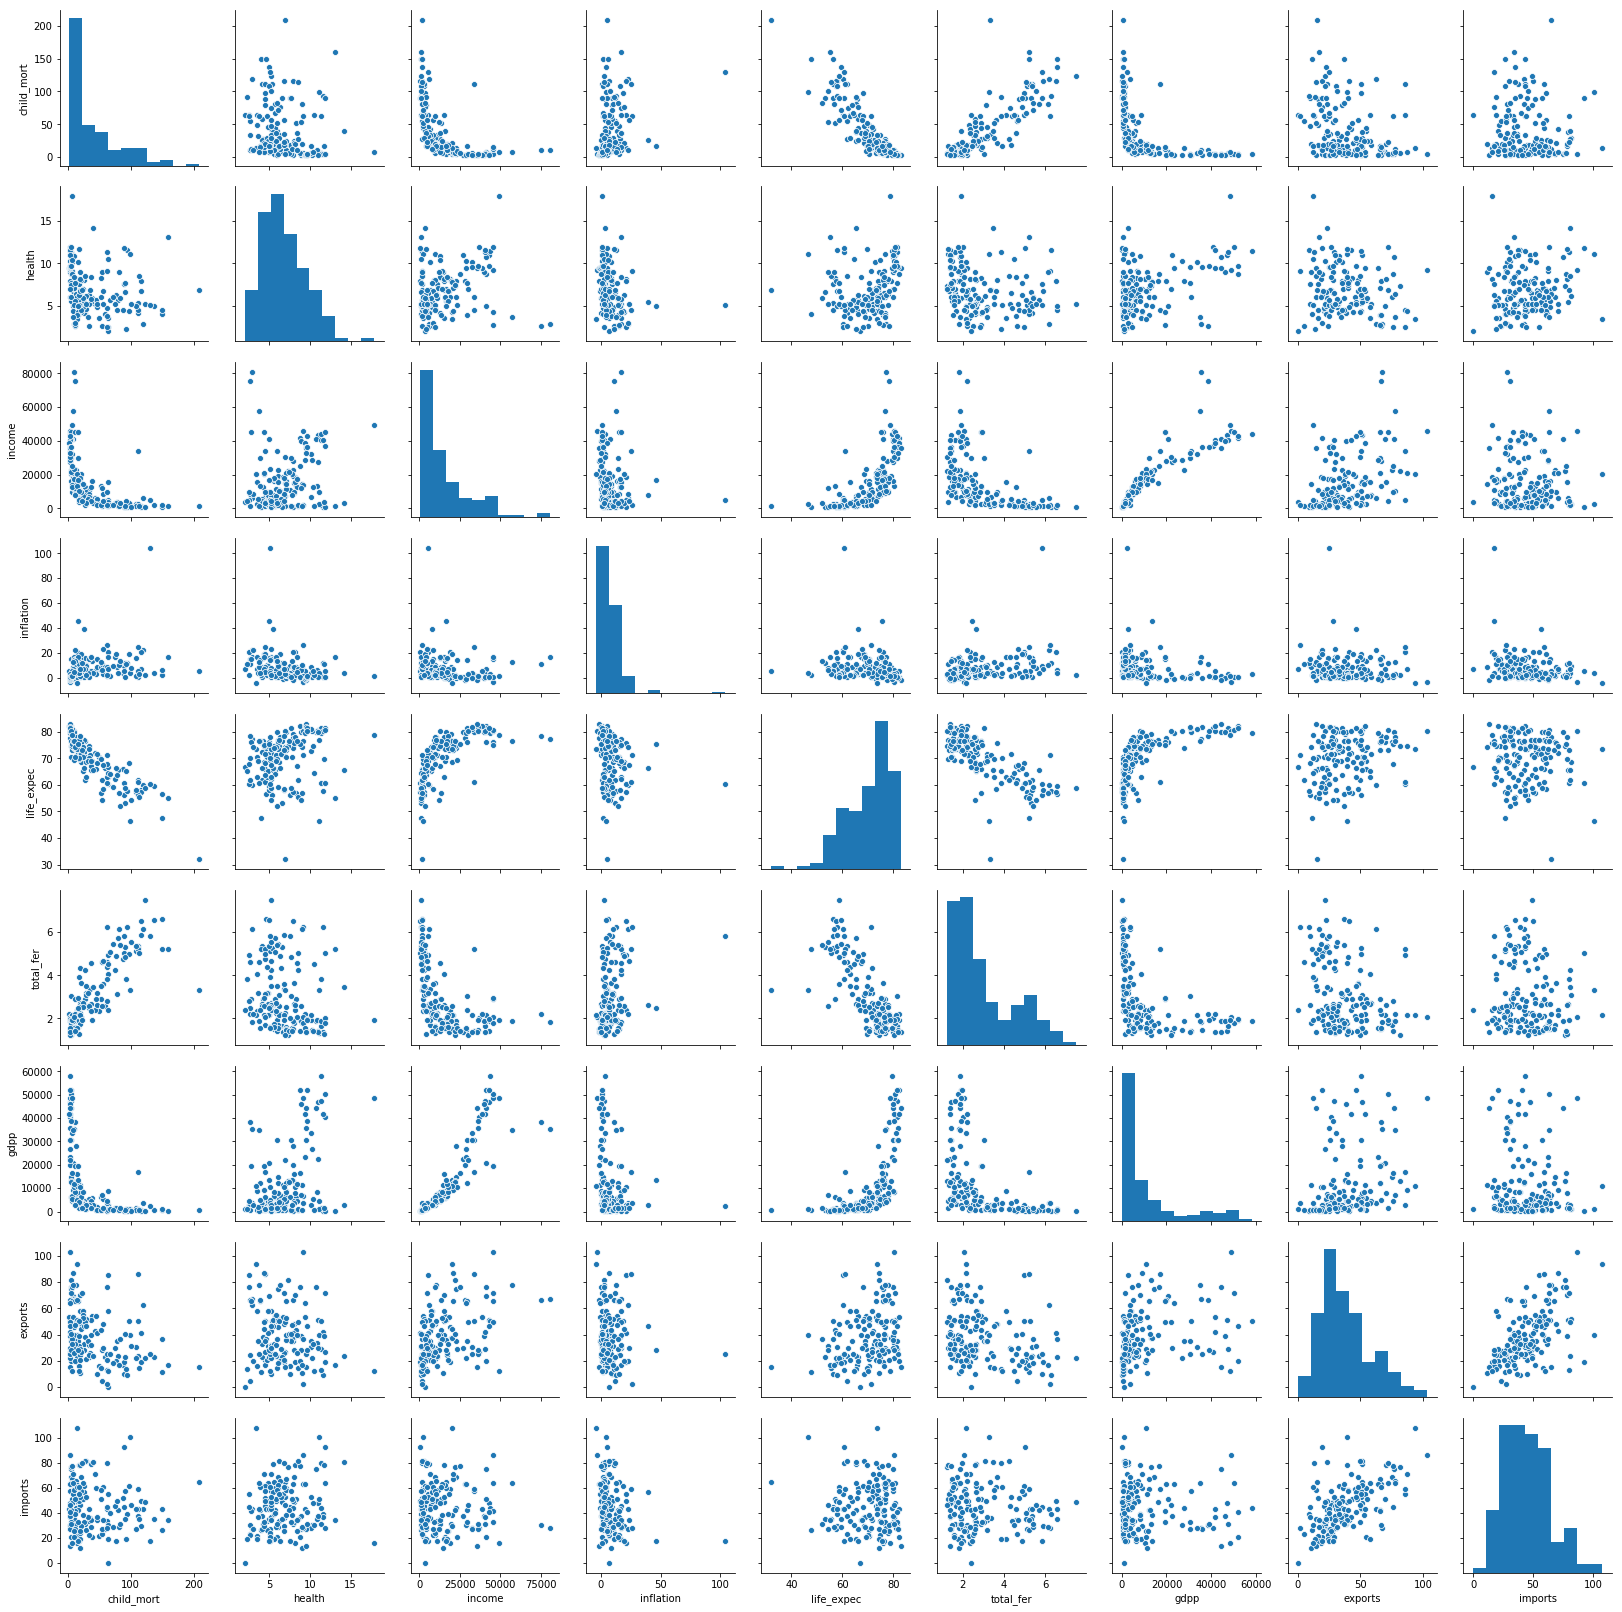

In [77]:
plt.figure(figsize = (20, 20))
numFeature = ['child_mort', 'health', 'income', 'inflation','life_expec','total_fer', 'gdpp','exports', 'imports']
sns.pairplot(countries[numFeature])
plt.show()

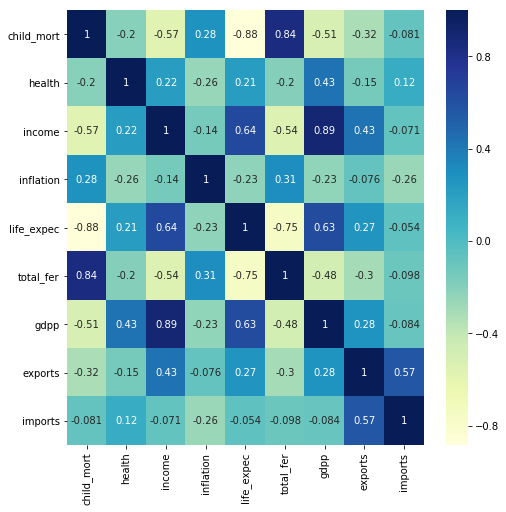

In [78]:
plt.figure(figsize = (8, 8))
sns.heatmap(countries[numFeature].corr(), annot = True, cmap="YlGnBu")
plt.show()

#High correlation between child_mort - total_fer, income-gdpp, life_expec-income, child_mort-life_expec
#we need to create Principle components in this case

In [79]:
#Normalizing Continuous features

countries_n = countries.loc[:,countries.columns !='country']

countries_norm =(countries_n-countries_n.mean())/countries_n.std()


In [80]:
countries_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.250129,-1.386260,0.285930,-0.008451,-0.884003,0.139578,-1.584439,1.859119,-0.725323
1,-0.565210,-0.505487,-0.092397,0.183955,-0.338078,-0.322129,0.696840,-0.887765,-0.478079
2,-0.301295,0.003404,-0.966591,-0.710474,-0.143199,0.760784,0.719539,-0.070946,-0.452216
3,1.960479,1.172875,-1.451438,-0.112455,-0.602510,1.348411,-1.141803,2.083086,-0.517224
4,-0.720599,0.350820,-0.283398,0.719572,0.263620,-0.606615,0.753588,-0.571577,0.088826


In [81]:
countries_normalized = pd.concat([countries.country, countries_norm],1)

In [82]:
countries_normalized.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,1.250129,-1.386260,0.285930,-0.008451,-0.884003,0.139578,-1.584439,1.859119,-0.725323
1,Albania,-0.565210,-0.505487,-0.092397,0.183955,-0.338078,-0.322129,0.696840,-0.887765,-0.478079
2,Algeria,-0.301295,0.003404,-0.966591,-0.710474,-0.143199,0.760784,0.719539,-0.070946,-0.452216
3,Angola,1.960479,1.172875,-1.451438,-0.112455,-0.602510,1.348411,-1.141803,2.083086,-0.517224
4,Antigua and Barbuda,-0.720599,0.350820,-0.283398,0.719572,0.263620,-0.606615,0.753588,-0.571577,0.088826


In [83]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [84]:
#Doing the PCA on the normalized data
pca.fit(countries_norm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [85]:
pca.components_

array([[ 0.43432949, -0.22349924, -0.17765077, -0.06086991, -0.41026258,
         0.18760454, -0.43659261,  0.41360806, -0.40118009],
       [ 0.00780068,  0.57934387, -0.15447574,  0.72921832, -0.12148415,
        -0.19320948, -0.12944755, -0.01658765, -0.19889094],
       [-0.08482327,  0.33238341, -0.67737657, -0.21658429,  0.18507586,
         0.5692903 ,  0.11986179, -0.0444433 , -0.0434964 ],
       [ 0.37507539,  0.27263034,  0.31157417,  0.08326891,  0.41620486,
         0.28087026, -0.24220336,  0.38572441,  0.47055138],
       [-0.2080867 , -0.04810031,  0.49722533,  0.25954138, -0.23390753,
         0.70916696,  0.12461522, -0.16797208, -0.19600368],
       [ 0.20882725, -0.050588  , -0.00119195, -0.04385663,  0.16516915,
         0.05632556, -0.59927031, -0.74988307, -0.00206634],
       [ 0.00991547, -0.64222521, -0.35327404,  0.58176104,  0.19223503,
         0.12515979,  0.05386133,  0.02060343,  0.26125694],
       [-0.68475814, -0.07580787,  0.04193716, -0.01691176,  0

In [86]:
pca.explained_variance_ratio_

array([0.45418002, 0.1712606 , 0.13563277, 0.10582955, 0.07164161,
       0.02574799, 0.0188075 , 0.00972738, 0.00717257])

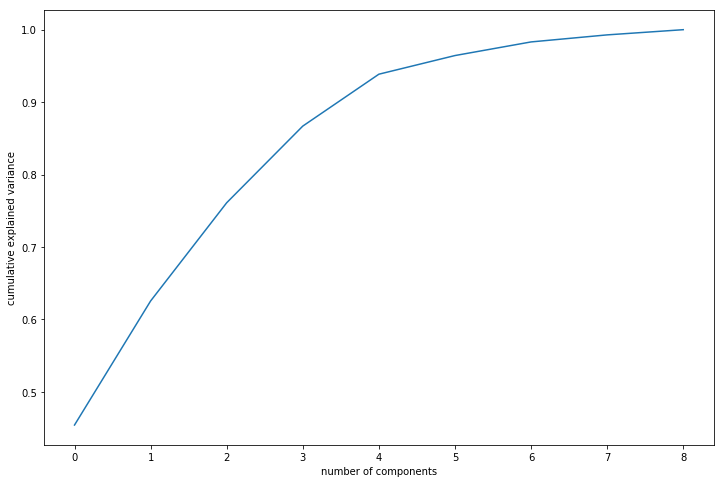

In [87]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [88]:
#Looks like 4 components are enough to explain >90% of variance... choosing 4 components

#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=4)

countries_norm_pca = pca_final.fit_transform(countries_norm)
countries_norm_pca.shape


(161, 4)

In [89]:
#Creating dataframe from PCA components
pc = np.transpose(countries_norm_pca)
df_pca = pd.DataFrame({'PC1':pc[0],'PC2':pc[1], 'PC3':pc[2],'PC4':pc[3]})

df_pca.index = list(countries['country'])

df_pca.head()

,PC1,PC2,PC3,PC4
Afghanistan,-2.943212,-0.467656,1.080196,0.595144
Albania,0.528066,-0.028337,0.182637,-1.348356
Algeria,-0.120782,-0.471386,-1.365710,-0.710046
Angola,-2.920567,0.891802,-1.651580,1.616279
Antigua and Barbuda,1.206331,0.735397,-0.041410,-0.617741


In [90]:
df_pca.shape

(161, 4)

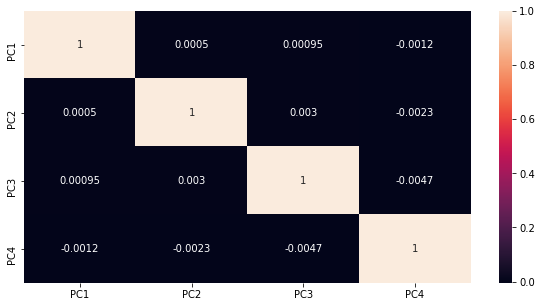

In [91]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(countries_norm_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (10,5))
#sns.heatmap(corrmat,annot = True)
sns.heatmap(df_pca.corr(),annot = True)

#As expected no coorelation is seen between Principal components

In [92]:
#Going ahead with Clustering now
df_pca.shape

(161, 4)

In [93]:
#KMeans clustering

#We need to first find out the K value, checking with Elbow method and silhouette_score both

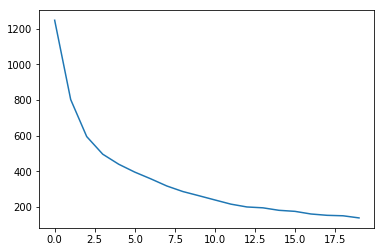

In [94]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_pca)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

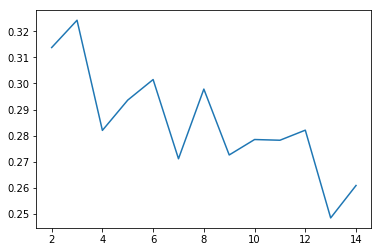

In [95]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(df_pca)
    sse_.append([k, silhouette_score(df_pca, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

In [96]:
#Going ahead with 3 clusters as clear from silhouette_score, maximum value is at 3

#K-mean clustering

model_countr1 = KMeans(n_clusters = 3, max_iter=50, init='k-means++', n_init=1, verbose=0, random_state=3425)
model_countr1.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=3425, tol=0.0001, verbose=0)

In [97]:
model_countr1.labels_
# analysis of clusters formed
countries_n.index = pd.RangeIndex(len(countries_n.index))
countries_km = pd.concat([countries_n, pd.Series(model_countr1.labels_)], axis=1)
countries_km.rename(index=str,columns={0:'ClusterID'}, inplace=True)
countries_km.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


In [98]:
df_clusterId = countries_km.groupby(['ClusterID']).mean()
df_clusterId

#Cluster-1 looks worst with high child_mort and lowest income

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
ClusterID,,,,,,,,,
0,5.821212,47.603030,8.753333,42.303030,40087.878788,3.270333,79.472727,1.852727,36090.909091
1,90.557143,29.447143,6.592041,43.906122,3885.979592,11.745612,59.365306,4.960816,1928.612245
2,21.931646,39.966949,6.116203,46.932480,11581.645570,7.537456,72.965823,2.258354,6001.417722


In [99]:
#Positive factors - income, life_expec, gdpp
#negative factors - child_mort, inflation, total_fer

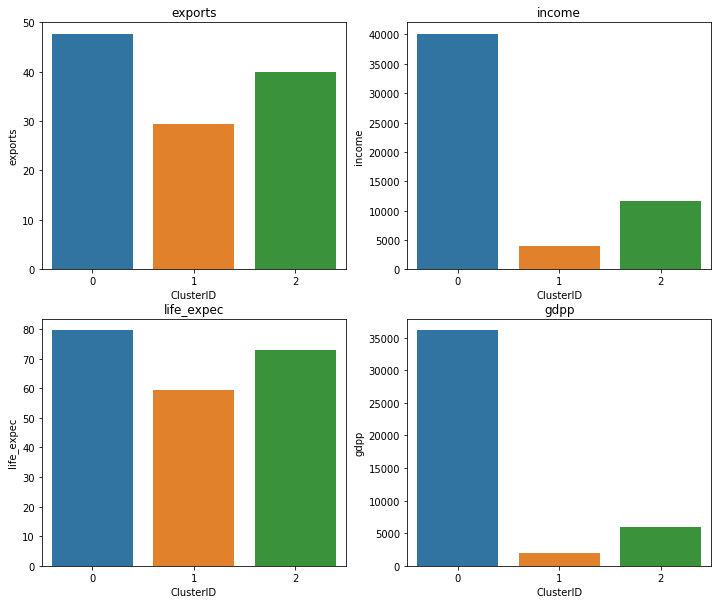

In [100]:
plt.figure(figsize=(12,10))

#Positive factors - exports, income, life_expec, gdpp
plt.subplot(2, 2, 1)
sns.barplot(x=df_clusterId.index, y='exports', data=df_clusterId)
plt.title("exports")


plt.subplot(2, 2, 2)
sns.barplot(x=df_clusterId.index, y='income', data=df_clusterId)
plt.title("income")

plt.subplot(2, 2, 3)
sns.barplot(x=df_clusterId.index, y='life_expec', data=df_clusterId)
plt.title("life_expec")

plt.subplot(2, 2, 4)
sns.barplot(x=df_clusterId.index, y='gdpp', data=df_clusterId)
plt.title("gdpp")


plt.show()

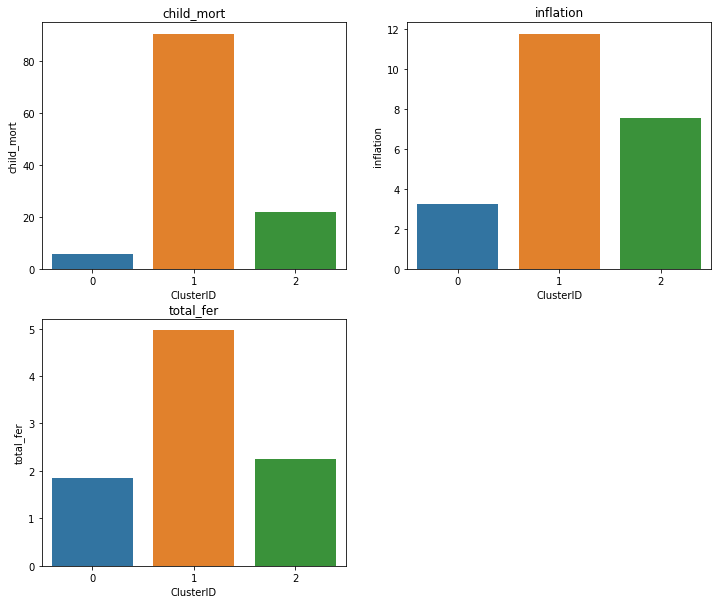

In [101]:
plt.figure(figsize=(12,10))
#child_mort, inflation, life_expec, total_fer

plt.subplot(2, 2, 1)
sns.barplot(x=df_clusterId.index, y='child_mort', data=df_clusterId)
plt.title("child_mort")


plt.subplot(2, 2, 2)
sns.barplot(x=df_clusterId.index, y='inflation', data=df_clusterId)
plt.title("inflation")

plt.subplot(2, 2, 3)
sns.barplot(x=df_clusterId.index, y='total_fer', data=df_clusterId)
plt.title("total_fer")

plt.show()

In [102]:
#Cluster #0 and #2 are Developed countries - High Positive Factors and Low Negative factors
#Cluster #1 is under developed countries
df_clusterId
df_clusterId.index

Int64Index([0, 1, 2], dtype='int64', name='ClusterID')

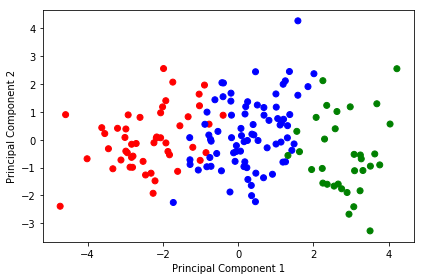

In [103]:
#Cluster Id using K-means
%matplotlib inline
fig = plt.figure(figsize = (6,4))
plt.scatter(df_pca.iloc[:,0], df_pca.iloc[:,1], c = countries_km.ClusterID.map({0:'green',1:'red',2:'blue'}))


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

Information on what is the purpose of each DF

Countries – main DF
countries_norm – normalized df having only features
countries_normalized – Column country and normalized features

PCA will be applied on countries_norm

Df_pca – country and 5 PCA columns
model_countr1 – after K means
countries_km – features and ClusterID

DF – countries + PCA components + clusterID

Countries + df_pca + ClusterID from countries_km


In [104]:
#Final Frame - Super set - Countries + df_pca + ClusterID from countries_km
countries_km.reset_index(inplace=True, drop=True)
countries.reset_index(inplace=True, drop=True)
df_pca.reset_index(inplace=True, drop=True)

finalDf = pd.concat([countries, df_pca,countries_km.ClusterID ], axis = 1)
finalDf.shape

finalDf.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,ClusterID
156,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,-0.826711,0.992141,0.041382,-0.525311,2
157,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,-0.216575,-1.879338,-2.671291,0.122630,2
158,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0.461686,2.443411,-0.255304,-0.470599,2
159,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,-1.822645,-0.542406,-0.965465,0.100400,1
160,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,-2.829341,-0.163335,-0.168761,0.875573,1


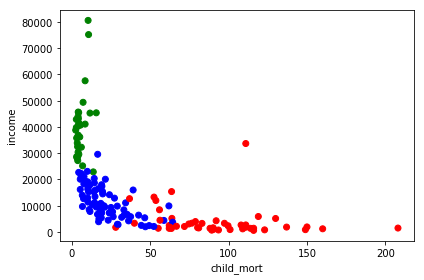

In [105]:
%matplotlib inline
fig = plt.figure(figsize = (6,4))
plt.scatter(finalDf.child_mort, finalDf.income, c = finalDf.ClusterID.map({0:'green',1:'red',2:'blue'}))
plt.xlabel('child_mort')
plt.ylabel('income')
plt.tight_layout()
plt.show()
#Cluster-1 is with high child_mort and low income

In [106]:
fdf1 = finalDf.loc[finalDf.ClusterID == 1]

In [107]:
#Filtering out poorest and unhealthy countries from cluster-1
fdf2 = fdf1.loc[(fdf1.child_mort > fdf1.child_mort.quantile(0.7)) & (fdf1.income < fdf1.income.quantile(0.3))]
fdf2.shape

(6, 15)

In [108]:
fdf2
#Below are the selected 5 countries which are in dire need of aid


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,ClusterID
31,Central African Republic,149.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,-4.011257,-0.684651,0.454477,0.672922,1
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334,-3.202747,0.410533,0.265160,1.682621,1
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,-3.005969,0.081288,-0.267942,0.763370,1
64,Guinea-Bissau,114.0,14.9,8.50,35.2,1390,2.97,55.6,5.05,547,-2.830736,-0.635192,1.468396,0.607408,1
110,Niger,123.0,22.2,5.16,49.1,814,2.55,58.8,7.49,348,-3.542057,0.220785,0.731358,1.016387,1
128,Sierra Leone,160.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,-3.326955,-1.044305,2.055883,1.893154,1


In [109]:
print(fdf2[['country','child_mort','income' ]])

                      country  child_mort  income
31   Central African Republic       149.0     888
37           Congo, Dem. Rep.       116.0     609
63                     Guinea       109.0    1190
64              Guinea-Bissau       114.0    1390
110                     Niger       123.0     814
128              Sierra Leone       160.0    1220


In [110]:
#Hierarchical clustering

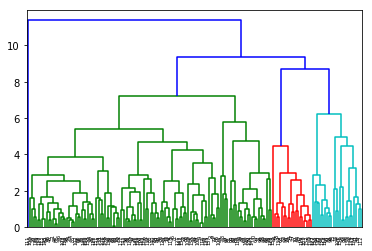

In [111]:
mergings = linkage(df_pca, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [112]:
#Going ahead with 3 clusters as seen from Dendogram, these clusters join after 8 as clear from y-axis
#Clusters on left side - all are with Green only thus cutting further at 4 cluster is not helping here
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))

clusterCut.tail()

156    0
157    0
158    1
159    0
160    0
dtype: int32

In [113]:
clusterCut.reset_index(inplace=True, drop=True)
countries_n.reset_index(inplace=True, drop=True)

countries_hc = pd.concat([countries_n,clusterCut ], axis=1)
countries_hc.tail()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
156,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0
157,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,0
158,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
159,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0
160,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0


In [114]:
countries_hc.rename(index=str,columns={0:'ClusterID'}, inplace=True)
countries_hc.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [115]:
df_clusterId_hc = countries_hc.groupby(['ClusterID']).mean()
df_clusterId_hc

#From below data, cluster-2 looks worst with high child_mort and low income followed by cluster-0

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
ClusterID,,,,,,,,,
0,50.541026,32.652983,6.358120,43.791162,7855.752137,8.731915,67.176068,3.385470,4043.111111
1,7.411628,54.081395,8.048372,49.165116,34976.511628,3.564674,78.504651,1.876512,29866.046512
2,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000


In [116]:
#Positive factors - income, life_expec, gdpp
#negative factors - child_mort, inflation, total_fer

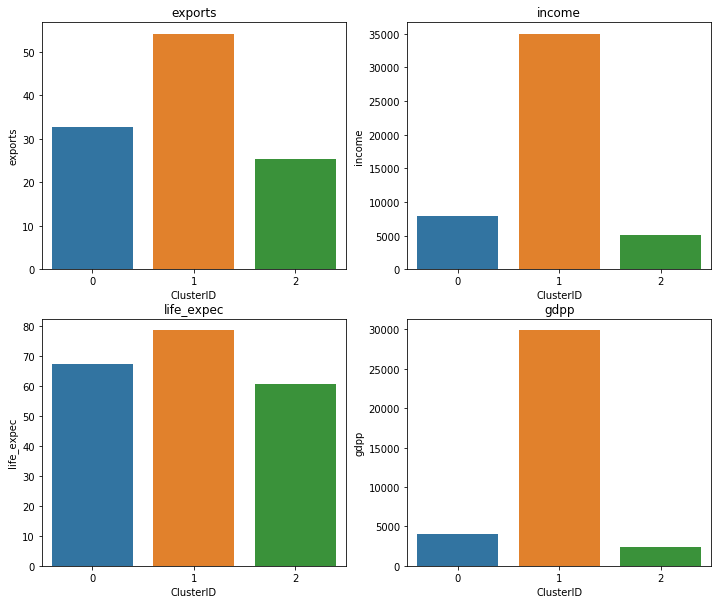

In [117]:
plt.figure(figsize=(12,10))

#Positive factors - exports, income, life_expec, gdpp
plt.subplot(2, 2, 1)
sns.barplot(x=df_clusterId_hc.index, y='exports', data=df_clusterId_hc)
plt.title("exports")


plt.subplot(2, 2, 2)
sns.barplot(x=df_clusterId_hc.index, y='income', data=df_clusterId_hc)
plt.title("income")

plt.subplot(2, 2, 3)
sns.barplot(x=df_clusterId_hc.index, y='life_expec', data=df_clusterId_hc)
plt.title("life_expec")

plt.subplot(2, 2, 4)
sns.barplot(x=df_clusterId_hc.index, y='gdpp', data=df_clusterId_hc)
plt.title("gdpp")


plt.show()

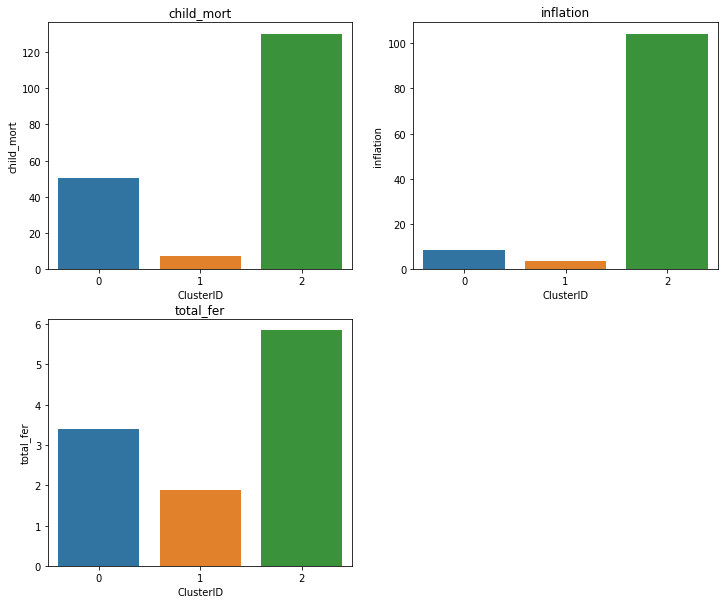

In [118]:
plt.figure(figsize=(12,10))
#child_mort, inflation, life_expec, total_fer

plt.subplot(2, 2, 1)
sns.barplot(x=df_clusterId_hc.index, y='child_mort', data=df_clusterId_hc)
plt.title("child_mort")


plt.subplot(2, 2, 2)
sns.barplot(x=df_clusterId_hc.index, y='inflation', data=df_clusterId_hc)
plt.title("inflation")

plt.subplot(2, 2, 3)
sns.barplot(x=df_clusterId_hc.index, y='total_fer', data=df_clusterId_hc)
plt.title("total_fer")

plt.show()

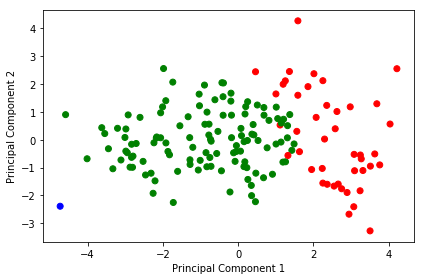

In [119]:
#Cluster Id using Hierarchical clustering
%matplotlib inline
fig = plt.figure(figsize = (6,4))
plt.scatter(df_pca.iloc[:,0], df_pca.iloc[:,1], c = countries_hc.ClusterID.map({0:'green',1:'red',2:'blue'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [120]:
#Final Frame - Super set - Countries + df_pca + ClusterID from countries_km
countries_hc.reset_index(inplace=True, drop=True)
countries.reset_index(inplace=True, drop=True)
df_pca.reset_index(inplace=True, drop=True)

finalDf_hc = pd.concat([countries, df_pca,countries_hc.ClusterID ], axis = 1)


In [121]:
finalDf_hc.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,-2.943212,-0.467656,1.080196,0.595144,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0.528066,-0.028337,0.182637,-1.348356,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,-0.120782,-0.471386,-1.365710,-0.710046,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,-2.920567,0.891802,-1.651580,1.616279,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1.206331,0.735397,-0.041410,-0.617741,0


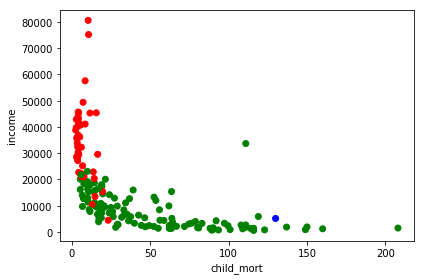

In [122]:
%matplotlib inline
fig = plt.figure(figsize = (6,4))
plt.scatter(finalDf_hc.child_mort, finalDf_hc.income, c = finalDf_hc.ClusterID.map({0:'green',1:'red',2:'blue'}))
plt.xlabel('child_mort')
plt.ylabel('income')
plt.tight_layout()
plt.show()
#Cluster-2 is with high child_mort and low income

In [123]:
fdf1_hc = finalDf_hc.loc[finalDf_hc.ClusterID == 2]
print(fdf1_hc[['country','child_mort','income' ]])
fdf1_hc
#Only 1 country in cluster-2, picking more countries from cluster-0

     country  child_mort  income
111  Nigeria       130.0    5150


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,ClusterID
111,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330,-4.726535,-2.39189,-4.749987,3.126227,2


In [124]:
fdf3_hc = finalDf_hc.loc[finalDf_hc.ClusterID == 0]

In [125]:
#Filtering out poorest and unhealthy countries from cluster-2
fdf2_hc = fdf3_hc.loc[(fdf3_hc.child_mort > fdf3_hc.child_mort.quantile(0.85)) & (fdf3_hc.income < fdf3_hc.income.quantile(0.1))]
fdf2_hc.shape

(6, 15)

In [126]:
fdf2_hc
#Below are the selected 5 countries which are in dire need of aid

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,ClusterID
31,Central African Republic,149.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,-4.011257,-0.684651,0.454477,0.672922,0
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334,-3.202747,0.410533,0.265160,1.682621,0
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,-3.005969,0.081288,-0.267942,0.763370,0
104,Mozambique,101.0,31.5,5.21,46.2,918,7.64,54.5,5.56,419,-2.980967,0.386083,0.274745,0.678489,0
110,Niger,123.0,22.2,5.16,49.1,814,2.55,58.8,7.49,348,-3.542057,0.220785,0.731358,1.016387,0
128,Sierra Leone,160.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,-3.326955,-1.044305,2.055883,1.893154,0


In [127]:
fdf2_hc[['country']]

,country
31,Central African Republic
37,"Congo, Dem. Rep."
63,Guinea
104,Mozambique
110,Niger
128,Sierra Leone
